## Kindle Reviews Sentiment Analysis

### Importing Libraries


In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
import string
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

### Loading Data

In [65]:
data=pd.read_csv('all_kindle_review.csv')
data.head()

,Unnamed: 0.1,Unnamed: 0,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600
1,1,5957,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1381190400
2,2,9146,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1397174400
3,3,7038,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1404518400
4,4,1776,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1356912000


In [66]:
data=data[['reviewText','rating']]
data.head()

,reviewText,rating
0,"Jace Rankin may be short, but he's nothing to ...",3
1,Great short read. I didn't want to put it dow...,5
2,I'll start by saying this is the first of four...,3
3,Aggie is Angela Lansbury who carries pocketboo...,3
4,I did not expect this type of book to be in li...,4


In [67]:
data.shape

(12000, 2)

In [68]:
data.isnull().sum()

reviewText    0
rating        0
dtype: int64

### Visualization

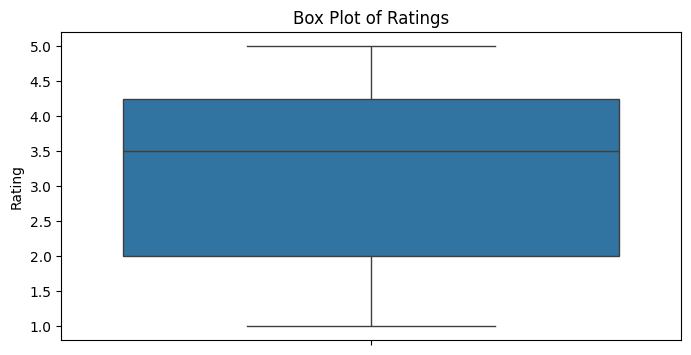

In [69]:
# Create a violin plot
plt.figure(figsize=(8, 4))
sns.boxplot(y=data['rating'])
plt.title('Box Plot of Ratings')
plt.ylabel('Rating')
plt.show()


C:\Users\SaadS\AppData\Local\Temp\ipykernel_16032\576205694.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating', y='count', data=rating_df, palette='viridis')


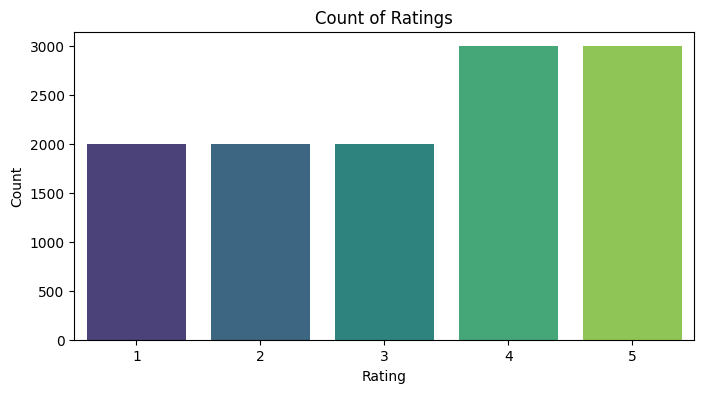

In [70]:
rating_counts = data['rating'].value_counts().sort_index()

# Create a DataFrame from the value counts
rating_df = rating_counts.reset_index()
rating_df.columns = ['rating', 'count']

# Create a bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x='rating', y='count', data=rating_df, palette='viridis')
plt.title('Count of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.show()

### Text Preprocessing

In [71]:
data["rating"]=data["rating"].apply(lambda x: 0 if x > 3 else 1)

In [72]:
data.rating.unique()

array([1, 0], dtype=int64)

### 1. Conversion to Lowercase

In [73]:
data['reviewText'] = data['reviewText'].str.lower()

### 2. Removing Urls

In [74]:
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)


In [75]:
data['reviewText'] = data['reviewText'].apply(remove_url)

### 3. Removing HTML Tags

In [76]:
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)



In [77]:
data['reviewText'] = data['reviewText'].apply(remove_html_tags)

### 4. Removing Punctuations

In [78]:
punct = string.punctuation
def remove_punct(text):
    return text.translate(str.maketrans('', '', punct))

In [79]:
data['reviewText'] = data['reviewText'].apply(remove_punct)

### 5. Replacing Short-Convo/Chat-Words

In [80]:
# Removing Short Convo / Chat Words
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [81]:
def chat_conversion(text):
    new_text = []
    for i in text.split():
        if i.upper() in chat_words:
            new_text.append(chat_words[i.upper()])
        else:
            new_text.append(i)
    return " ".join(new_text)

In [82]:
data['reviewText'] = data['reviewText'].apply(chat_conversion)

### 6. Spelling Correction

In [83]:
def correct_spell(text):
    return str(TextBlob(text).correct())


In [45]:
data['reviewText'] = data['reviewText'].apply(correct_spell)

KeyboardInterrupt: 

### 7. Removing Stopwords

In [84]:
stopword = set(stopwords.words('english'))
def remove_stopwords(text):
    new_text = []
    
    for word in text.split():
        if word in stopword:
            new_text.append('')
        else:
            new_text.append(word)
    x = new_text[:]
    new_text.clear()
    return " ".join(x)

In [85]:
data['reviewText'] = data['reviewText'].apply(remove_stopwords)

### 8. Removing Emojis

In [86]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [87]:
data['reviewText'] = data['reviewText'].apply(remove_emoji)

In [88]:
data.head()

,reviewText,rating
0,jace rankin may short hes nothing mess m...,1
1,great short read didnt want put read ...,0
2,ill start saying first four books wasnt...,1
3,aggie angela lansbury carries pocketbooks in...,1
4,expect type book library pleased fin...,0


### 9. Lemmatization

In [89]:
lemmatizer = WordNetLemmatizer()

In [90]:
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


In [91]:
data['reviewText']=data['reviewText'].apply(lambda x:lemmatize_words(x))

### Model Training

In [92]:
X_train, X_test, y_train, y_test = train_test_split(data['reviewText'], data['rating'], test_size=0.2, random_state=42)

### Vectorization

### Bag of Words

In [93]:
cv=CountVectorizer()
X_train_bow=cv.fit_transform(X_train)
X_test_bow=cv.transform(X_test)


### TF-IDF

In [94]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf=tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf=tfidf_vectorizer.transform(X_test)


### Model Evaluation

In [99]:
from sklearn.naive_bayes import GaussianNB
nb_model=GaussianNB()
nb_model_bow=nb_model.fit(X_train_bow.toarray(),y_train)
nb_model_tfidf=nb_model.fit(X_train_tfidf.toarray(),y_train)


In [101]:
y_pred_bow=nb_model_bow.predict(X_test_bow.toarray())

In [102]:
y_pred_tfidf=nb_model_tfidf.predict(X_test_tfidf.toarray())

In [103]:
print('Accuracy of Naive Bayes Model using Bag of Words:',accuracy_score(y_test,y_pred_bow))

Accuracy of Naive Bayes Model using Bag of Words: 0.67125


In [105]:
confusion_matrix(y_test,y_pred_bow)

array([[815, 395],
       [394, 796]], dtype=int64)

In [104]:
print('Accuracy of Naive Bayes Model using TF-IDF:',accuracy_score(y_test,y_pred_tfidf))

Accuracy of Naive Bayes Model using TF-IDF: 0.62875


In [106]:
confusion_matrix(y_test,y_pred_tfidf)

array([[715, 495],
       [396, 794]], dtype=int64)